In [1]:
#from package import menu_cost, jacobian, chebnew_dropbox as cheb
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size' : 20, 'lines.linewidth' : 3.5, 'figure.figsize' : (11,6)})

# Part 1: build time-dependent Jacobians
First let's build the fake news pass-through matrix for a generalized time-dependent model, given the survival function $\Phi_0,\Phi_1,\ldots$.

This is just the outer product of the column vector $(\Phi_0,\Phi_1,\ldots)$ and the row vector $(\Phi_0,\beta\Phi_1,\ldots)$, with both normalized so that they sum to one:

In [2]:
def F_passthrough_for_td(Phi, beta):
    columns = beta**np.arange(len(Phi))*Phi
    columns /= columns.sum()

    rows = Phi / Phi.sum()
    return np.outer(rows, columns)

Now let's write generic code to build a Jacobian from a fake news matrix, allowing in this case the Jacobian to be larger than the original fake news matrix (we'll sometimes want larger Jacobians to do the sequence-space calculations very accurately).

In [3]:
def J_from_F(F, T=300):
    """From fake news matrix F (possibly smaller than T*T), build Jacobian J of size T*T"""

    if T < len(F):
        raise ValueError(f"T={T} must be weakly larger than existing size of F, {len(F)}")

    J = np.zeros((T, T))
    J[:len(F), :len(F)] = F
    for t in range(1, J.shape[1]):
        J[1:, t] += J[:-1, t - 1]
    return J

We can combine these to get simple code for the pass-through matrix of a TD model:

In [4]:
def passthrough_for_td(Phi, beta, T=300):
    return J_from_F(F_passthrough_for_td(Phi, beta), T)

Let's try the simple case of Calvo and plot some columns:

In [5]:
theta = 0.75 # adjustment once every four quarters
beta = 0.99
Psi_calvo = passthrough_for_td(theta**np.arange(300), beta, T=300)

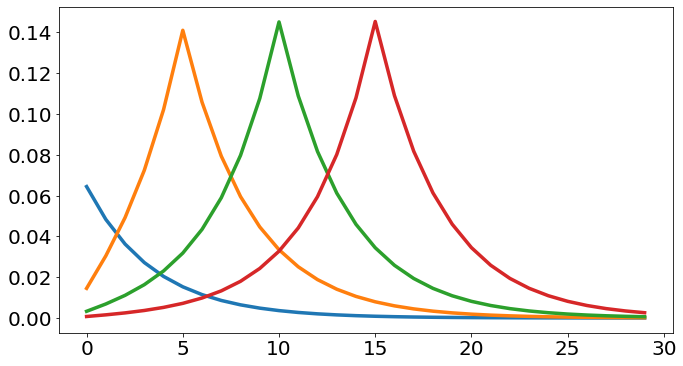

In [6]:
plt.plot(Psi_calvo[:30, [0, 5, 10, 15]]);

Now let's write code to get the Generalized Phillips curve (GPC). We'll write a generalized function that simply solves $\mathbf{K} = (I-L)(I-\Psi)^{-1}\Psi$, where $\Psi$ is the pass-through matrix.

In [7]:
def GPC_from_passthrough(Psi):
    K = np.linalg.solve(np.eye(len(Psi)) - Psi, Psi)
    K[1:, :] = K[1:, :] - K[:-1, :]
    return K

Let's tie this together to write a function to get the GPC straight from the survival curve $\Phi$. To avoid any truncation error, it's best to usually be quite aggressive and use a very large Jacobian `Psi` in the above:

In [8]:
def GPC_for_td(Phi, beta, T=1000):
    return GPC_from_passthrough(passthrough_for_td(Phi, beta, T))

Apply to the Calvo case and we see the standard New Keynesian Phillips curve: no inertia, but lots of anticipation with small discounting of `beta`:

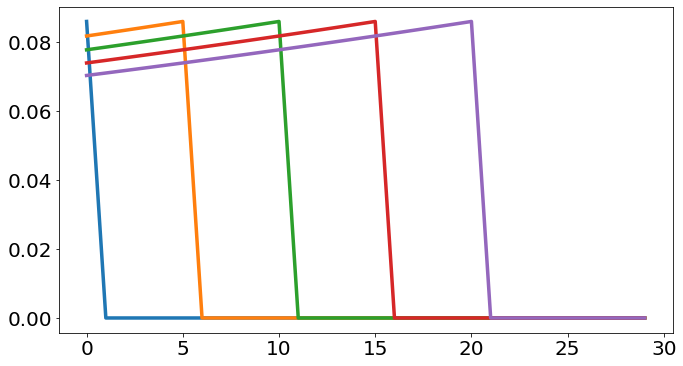

In [9]:
K_calvo = GPC_for_td(theta**np.arange(300), beta)[:300, :300] # once we've already solved, don't need far-out
plt.plot(K_calvo[:30, [0, 5, 10, 15, 20]]);

Let's apply to a different case with a simple example of an increasing hazard function. Here, we clearly see the *inertia* of inflation that is a property of the increasing-hazard case: some inflation persists after the real marginal cost shock. That's because the people who are adjusting after the shock are typically the ones who haven't adjusted for a while, and they need to catch up more.

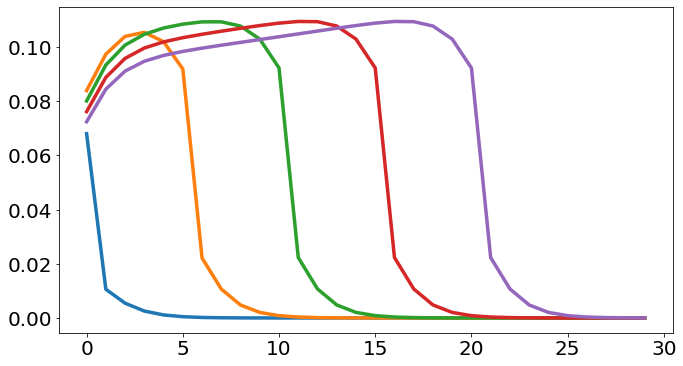

In [10]:
hazard = 0.3*(1-0.6**np.arange(300)) # increasing hazard
Phi_increasinghazard = np.cumprod(1-hazard)
K_increasinghazard = GPC_for_td(Phi_increasinghazard, beta)
plt.plot(K_increasinghazard[:30, [0, 5, 10, 15, 20]]);

Could also go to the other side of Calvo (which is constant-hazard) and do decreasing-hazard:

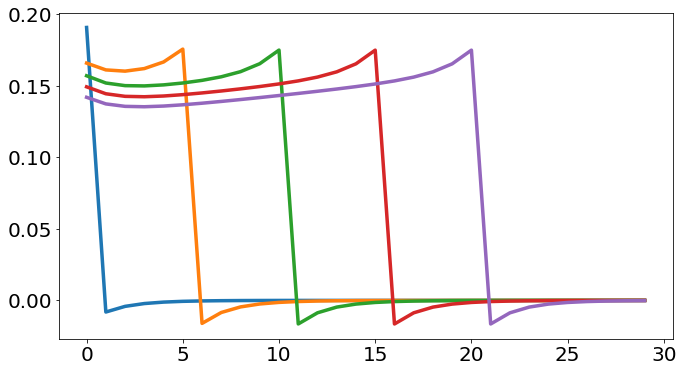

In [11]:
hazard = 0.3*(1+0.3*0.8**np.arange(300)) # decreasing hazard
Phi_decreasinghazard = np.cumprod(1-hazard) / (1-hazard[0]) # normalize initial Phi t o1
K_decreasinghazard = GPC_for_td(Phi_decreasinghazard, beta)
plt.plot(K_decreasinghazard[:30, [0, 5, 10, 15, 20]]);

Here we get anti-inertia, with inlfation going down after the shock.

# Part 2: build menu cost Jacobians
Here we'll need some specialized code in `menu_cost.py` (which also calls on simple libraries for Chebyshev interpolation and Gauss-Legendre quadrature) that we don't have time to cover in detail. This runs very quickly after the first time it's done (when a lot of Numba compilation is needed).

In [12]:
from menucost import menu_cost

In [13]:
# calibration of example Golosov-Lucas calibration: no drift, ideal point is 0
GL = dict(lamb=0, c=0.015, sigma=0.1, a=-0.2, b=0.2, ideal=0, mu=0)

In [14]:
Psi_menu, K_menu, (xstar, x_l, x_h), (p, f), weights, Es, Phis, Jnoms = (
                menu_cost.solve(GL['c'], 0, beta, GL['lamb'], 0, GL['sigma'], GL['a'], GL['b']))

Can see lower and upper adjustment bands, plus optimal point:

In [15]:
xstar, x_l, x_h

(0.0, -0.1434460471936126, 0.1434460471936141)

How many people reset each period?

In [16]:
p

0.232096659927073

What's the end-of-period density of the people who didn't reset?

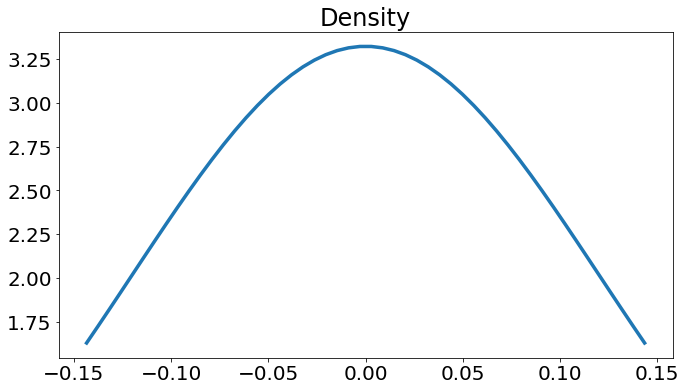

In [17]:
x = np.linspace(x_l, x_h, 50)
plt.plot(x, f(x))
plt.title('Density');

**Dynamics.** Now on to dynamics.

What are the weights on the intensive margin and vs. the extensive margin of the equivalent mixture (due to symmetry here, the extensive margins are identical)? Higher extensive-margin weight!

In [18]:
weights[0], 1-weights[0]

(0.38051526439367456, 0.6194847356063254)

Let's plot the two hazards.

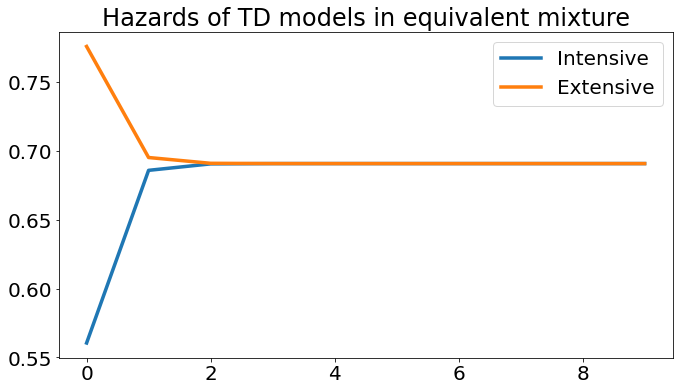

In [19]:
plt.plot(1 - Phis[0][1:11]/Phis[0][0:10], label='Intensive')
plt.plot(1 - Phis[1][1:11]/Phis[1][0:10], label='Extensive')
plt.title('Hazards of TD models in equivalent mixture')
plt.legend();

Plot some columns of the pass-through matrix:

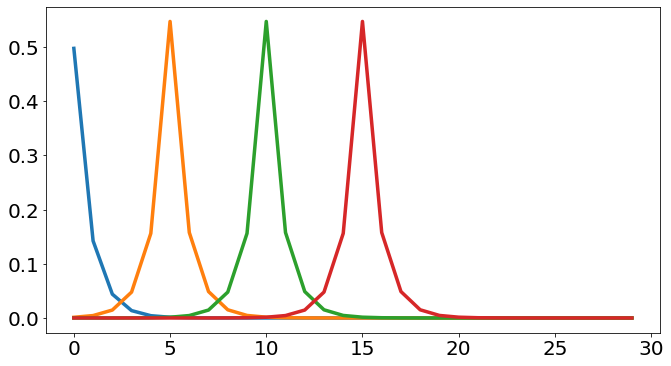

In [20]:
plt.plot(Psi_menu[:30, [0, 5, 10, 15]]);

And of the Generalized Phillips curve, which in this case looks very similar to a Calvo New Keynesian Phillips curve, with only minor jitters around the time of the real marginal cost shock:

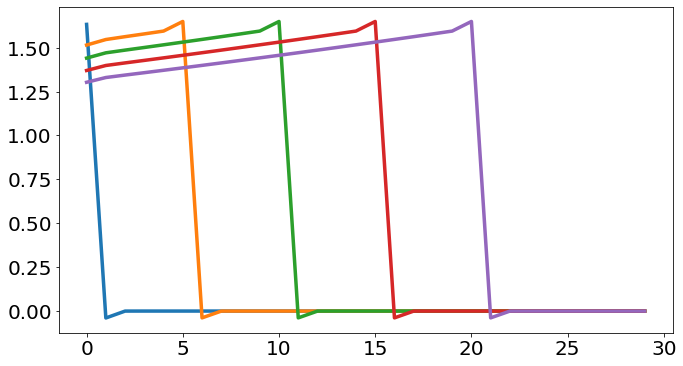

In [21]:
plt.plot(K_menu[:30, [0, 5, 10, 15, 20]]);

(But note the scale! This is vastly more flexible than our Calvo parametrization, even though people adjust slightly less often. So while menu cost models like Golosov-Lucas have an extremely similar functional form to Calvo, they have a very different flexibility parameter when calibrating to similar price adjustment rates - this was already a well-known point, and makes it even more difficult for these models to match empirical Phillips curves.)